# Importando conjunto de dados

Como a preguiça fala mais alto, vamos usar a biblioteca requests para importar o conjunto de dados, assim não precisamos fazer o download e o upload no Colab toda vez que formos rodar o notebook.

In [ ]:
import requests, io, zipfile

r = requests.get('https://caelum-online-public.s3.amazonaws.com/985-geopandas/01/Mapas.zip', stream=True)
zip = zipfile.ZipFile(io.BytesIO(r.content))
zip.extractall()

Como o geopandas não costuma estar instalado nas máquinas do Colab, vamos fazer sua instalação. O  "> /dev/null" só impede o output imenso do download da lib e das dependências.

In [ ]:
!pip install geopandas > /dev/null

# Shapefiles

Um dos arquivos extraídos da pasta acima é um shapefile do rio de janeiro, com a extensão ".shp". Um shapefile basicamente guarda as informações geográficas que podem ser usadas pelo GeoPandas para criar um GeoDataFrame. Abaixo, vamos ler esse shapefile.

In [ ]:
import geopandas as gpd
rj = gpd.read_file('/content/Mapas/RJ/33MUE250GC_SIR.shp')
rj.head()

,ID,CD_GEOCODM,NM_MUNICIP,geometry
0,1468,3300100,ANGRA DOS REIS,"MULTIPOLYGON (((-44.33208 -23.02384, -44.33221..."
1,1469,3300159,APERIBÉ,"POLYGON ((-42.08950 -21.62893, -42.08912 -21.6..."
2,1470,3300209,ARARUAMA,"POLYGON ((-42.22526 -22.59253, -42.22521 -22.5..."
3,1471,3300225,AREAL,"POLYGON ((-43.16007 -22.20005, -43.16003 -22.1..."
4,1472,3300233,ARMAÇÃO DOS BÚZIOS,"MULTIPOLYGON (((-41.98427 -22.74458, -41.98296..."


Uma das colunas de todo shapefile é o `geometry`. Nessa coluna existem as informações necessárias para que seja plotado um mapa, e é ela que diferencia um GeoDataFrame de um DataFrame normal. Com ela, já conseguimos plotar o rio de janeiro:

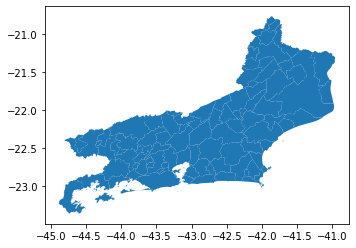

In [ ]:
rj.plot()

Apesar de nos referirmos ao shapefile como um só arquivo, ele é composto por vários arquivos diferentes com o mesmo nome e diferentes extensões. Alguns deles são obrigatórios para garantir o funcionamento correto, e outros são opcionais. Abaixo, vamos filtrar apenas o município do rio de janeiro e salvar nosso arquivo em uma nova pasta. Perceba como são criados vários arquivos, e não só o .shp, que é o que lemos.

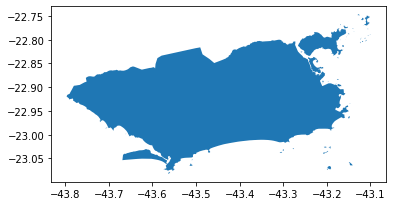

In [ ]:
rj_muni = rj[rj.NM_MUNICIP == 'RIO DE JANEIRO']
rj_muni.plot()

In [ ]:
import os
if not os.path.exists('RJ_MUNI'): os.mkdir('RJ_MUNI')
rj_muni.to_file('RJ_MUNI/RJ_MUNI.shp')

# Interlúdio - desenhando com shapely!

O shapely é a biblioteca que o GeoPandas utiliza para desenhar as figuras geométricas no plano cartesiano. Abaixo, temos uma carinha.

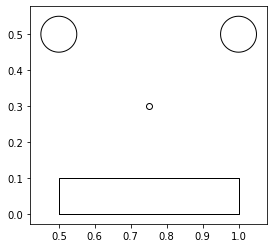

In [ ]:
from shapely.geometry import Point, Polygon

p1 = Point(0.5, 0.5).buffer(0.05)
p2 = Point(1, 0.5).buffer(0.05)
p3 = Point(0.75, 0.3)
p4 = Polygon([(0.5,0), (1,0), (1,0.1), (0.5,0.1)])

g = gpd.GeoSeries([p1, p2, p3, p4])
g.plot(color='white', edgecolor='black')

# GeoDataFrame a partir de LatLong

Mesmo quando temos apenas informações de latitude e longitude (LatLong), podemos transformar nosso DataFrame num GeoDataFrame, como faremos abaixo. Primeiro, vamos importar o novo conjunto de dados, com imóveis ofertados para venda, e sua localização de latitude e longitude. Faremos a importação novamente utilizando a biblioteca requests.

In [ ]:
r = requests.get('https://caelum-online-public.s3.amazonaws.com/985-geopandas/02/dados.zip', stream=True)
zip = zipfile.ZipFile(io.BytesIO(r.content))
zip.extractall()

Perceba que na tabela abaixo não temos a coluna geometry, e por isso não conseguiríamos plotar o conjunto de dados com o GeoPandas. Temos, no entanto, as colunas de Latitude e Longitude.

In [ ]:
import pandas as pd
imoveis = pd.read_table('dados.txt')
imoveis.head()

,Area,Bairro,Cidade,Endereco,Estado,Latitude,Longitude,Quartos,Suites,Vagas,Tipo,Transacao,Valor
0,138,Recreio dos Bandeirantes,Rio de Janeiro,Rua Vicente Scofano,RJ,-23.016455,-43.462946,3,1,3,Apartamento,Venda,1095000
1,133,Freguesia (Jacarepaguá),Rio de Janeiro,Rua Potiguara,RJ,-22.943199,-43.336911,3,1,2,Apartamento,Venda,650000
2,46,Pilares,Rio de Janeiro,Rua Professor Carneiro Felipe,RJ,-22.873849,-43.300517,1,0,0,Apartamento,Venda,150000
3,65,Barra da Tijuca,Rio de Janeiro,Avenida Salvador Allende,RJ,-22.984787,-43.412703,2,1,1,Apartamento,Venda,430000
4,85,Gávea,Rio de Janeiro,Rua Marquês de São Vicente,RJ,-14.235004,-51.925280,2,1,2,Apartamento,Venda,1800000


In [ ]:
geometry = [Point(x) for x in __builtins__.zip(imoveis.Longitude, imoveis.Latitude)]
geometry[:5]

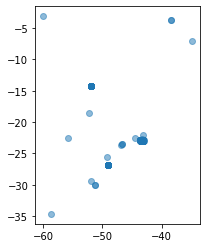

In [ ]:
crs = {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}
geo_dados = gpd.GeoDataFrame(imoveis, crs = crs, geometry = geometry)
geo_dados.plot(alpha=0.5)

# Sistema de coordenadas (CRS)

O CRS (sistema de referência de coordenadas) é uma forma padronizada de escrever localizações no globo terrestre. É necessário definí-lo para que seja usada a mesma representação em todos os GeoDataFrames usados no projeto: se o seu CRS não for igual, eles não serão comparáveis. Existem 3 parâmetros que sempre devem aparecer num crs:

```
crs = {
    'proj':'latlong',
    'ellps':'WGS84',
    'datum':'WGS84'
    } 
```

'Proj' se refere à projeção cartográfica que estamos utilizando. O parâmetro 'ellps' define a forma da Terra, e existem algumas elipses comumente utilizadas ('GRS80', 'WGS84' e 'CLRK80'). Por fim, o Datum determina a origem e a direção dos eixos das coordenadas. Um deles é o 'WGS84', mas o oficial do Brasil é o 'SIRGAS2000', por representar melhor a América Latina.

In [ ]:
geo_dados.crs

<Geographic 2D CRS: +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs + ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
rj_muni.crs

<Geographic 2D CRS: EPSG:4674>
Name: SIRGAS 2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Latin America - Central America and South America - onshore and offshore. Brazil - onshore and offshore.
- bounds: (-122.19, -59.87, -25.28, 32.72)
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Perceba que os CRSs dos GeoDataFrames são diferentes. Dessa forma, teremos que converter ambos para a mesma representação, e só assim poderemos trabalhar com os dois ao mesmo tempo.

Felizmente, em https://spatialreference.org/ podemos copiar os parâmetros de uma projeção específica que quisermos, e definir o crs de ambos como a projeção escolhida. Pesquisando "sirgas 2000" (a projeção usada no Brasil), escolhemos o arquivo EPSG:31983: SIRGAS 2000 / UTM zone 23S. Isso porque o Rio de Janeiro está na zona 23 Sul (imagem abaixo).

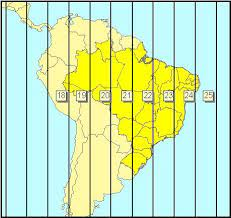

Se clicarmos em "Proj4", teremos uma string com a projeção pronta. Agora é só copiar e colar \o/

In [ ]:
rj_muni.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs', inplace=True)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
rj_muni.crs

<Bound CRS: +proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0, ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (kilometre)
- N[north]: Northing (kilometre)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from unknown to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: Unknown based on GRS80 ellipsoid
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Source CRS: unknown

In [ ]:
geo_dados.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs', inplace=True)

In [ ]:
geo_dados.crs

<Bound CRS: +proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0, ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (kilometre)
- N[north]: Northing (kilometre)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from unknown to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: Unknown based on GRS80 ellipsoid
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Source CRS: unknown

E pronto! Agora nossos GeoDataFrames estão com o mesmo CRS, e podemos trabalhar com os dois juntos ao mesmo tempo.

# Plotando!

Finalmente, podemos plotar nossos dois GeoDataFrames juntos. Utilizaremos o mapa do Rio de Janeiro como base, e plotaremos os pontos em cima. Para filtrar apenas os pontos que estão dentro do Rio de Janeiro, utilizamos a função "within".

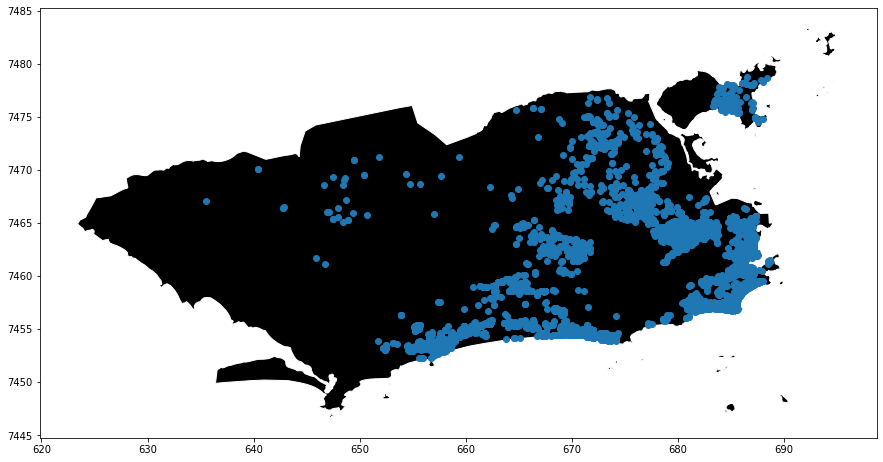

In [ ]:
base = rj_muni.plot(color='black', edgecolor='white', figsize=(15, 8))
geo_dados = geo_dados[geo_dados['geometry'].within(rj_muni.iloc[0]['geometry'])]
geo_dados.plot(ax=base)

# Calculando distâncias

Para esta etapa, queremos uma nova feature: a distância até a estação de metrô mais próxima para cada imóvel. Para isso, pecisaremos de outro conjunto de dados, que será lido a seguir.

In [ ]:
r = requests.get('https://caelum-online-public.s3.amazonaws.com/985-geopandas/05/Transporte.zip', stream=True)
zip = zipfile.ZipFile(io.BytesIO(r.content))
zip.extractall()

In [ ]:
metro = gpd.read_file('Transporte/Metrô/Estações_Metrô.geojson')
metro.head()

,OBJECTID,Cod,Nome,Flg_ATM,Flg_Bicicletario,Flg_Elevador,Flg_Linha1,Flg_Linha2,Obs,Flg_Ativa,Status,Data_Inc,Flg_Linha4,Integra_Trem,Integra_Onibus,Integra_BRT,Corredor,Integra_VLT,Onibus,Flg_Metro_Superficie,Metro_Superficie,Data_Inauguracao,geometry
0,1,1,Pavuna,1,1.0,1.0,0,1,None,1,None,None,0,1,0,0,None,0,None,0,None,1998,POINT (-43.36485 -22.80662)
1,2,2,Engenheiro Rubens Paiva,1,1.0,1.0,0,1,None,1,None,None,0,0,0,0,None,0,None,0,None,1998,POINT (-43.35845 -22.81627)
2,3,3,Acari / Fazenda Botafogo,0,0.0,0.0,0,1,None,1,None,None,0,0,0,0,None,0,None,0,None,1998,POINT (-43.34964 -22.82452)
3,4,4,Coelho Neto,1,0.0,0.0,0,1,None,1,None,None,0,0,0,0,None,0,None,0,None,1998,POINT (-43.34326 -22.83148)
4,5,5,Colégio,1,1.0,0.0,0,1,None,1,None,None,0,0,0,0,None,0,None,0,None,1998,POINT (-43.33386 -22.84269)


Como já vimos antes, temos que modificar o crs deste novo GeoDataFrame. Isso é feito abaixo.

In [ ]:
metro.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs', inplace=True)

Agora que já temos os novos dados no mesmo formato, podemos plotar na nossa base. Abaixo, plotamos um mapa (que sem querer virou comunista):

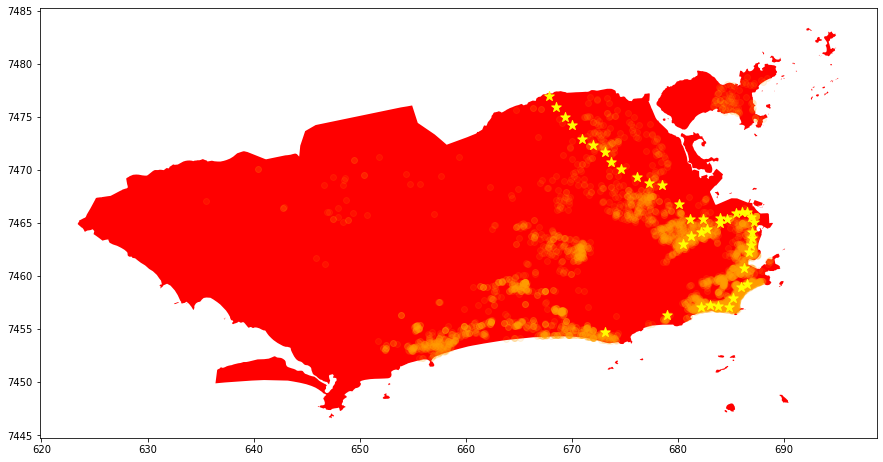

In [ ]:
base = rj_muni.plot(color='red', figsize=(15, 8))
geo_dados.plot(ax=base, color='orange', alpha=0.1)
metro.plot(ax=base, color='yellow', marker='*', markersize=100)

Para calcular a distância, podemos usar a função `distance` do geopandas. Abaixo, criamos uma função lambda que já calcula as distâncias de todas as estações de metrô e pega o mínimo, para cada imóvel.

In [ ]:
geo_dados['min_dist_metro'] = geo_dados['geometry'].apply(lambda i: metro.distance(i).min())

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Distância de novo só que pra trem

É só isso mesmo.

In [ ]:
trem = gpd.read_file('Transporte/Trem/Estações_Trem.geojson')
trem.head()

,OBJECTID,Cod,Nome,Flg_IntegraOnibus,Flg_IntegraMetro,Flg_Terminal,Flg_TransfRamal,Flg_TransfCentral,Flg_IntegraTele,Flg_Mun,Flg_Ativa,Status,Flg_BelfordRoxo,Flg_Saracuruna,Flg_Deodoro,Flg_SantaCruz,Flg_Japeri,Flg_Paracambi,Flg_VilaInhomirim,Flg_Guapimirim,Data_Inc,Integra_BRT,Corredor_BRT,geometry
0,1,60,Nova Iguaçu,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,None,NaN,None,POINT (-43.44939 -22.76073)
1,2,20,Comendador Soares,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,None,NaN,None,POINT (-43.48895 -22.74415)
2,3,4,Austin,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,None,NaN,None,POINT (-43.52271 -22.72031)
3,4,81,Queimados,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,None,NaN,None,POINT (-43.55610 -22.71624)
4,5,29,Engenheiro Pedreira,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,None,NaN,None,POINT (-43.60606 -22.67875)


In [ ]:
trem.to_crs('+proj=utm +zone=23 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=km +no_defs', inplace=True)

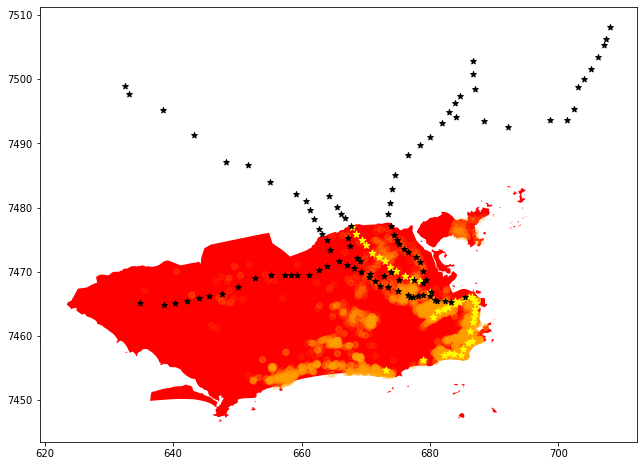

In [ ]:
base = rj_muni.plot(color='red', figsize=(15, 8))
geo_dados.plot(ax=base, color='orange', alpha=0.1)
metro.plot(ax=base, color='yellow', marker='*', markersize=50)
trem.plot(ax=base, color='black', marker='*')

In [ ]:
geo_dados['min_dist_trem'] = geo_dados['geometry'].apply(lambda i: trem.distance(i).min())

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Aehooo